<a href="https://colab.research.google.com/github/rosacarla/Sistema-deteccao-de-faces-OpenCV-ResNet/blob/main/face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SISTEMA DE DETECÇÃO DE FACES HUMANAS 

#### Descrição: Este sistema deve ser capaz de detectar a região que representa a face de uma pessoa, assim dá suporte para o sistema de classificação reconhecer a pessoa em questão.
#### Autora: Carla Edila Silveira
#### Data: 22/06/2022

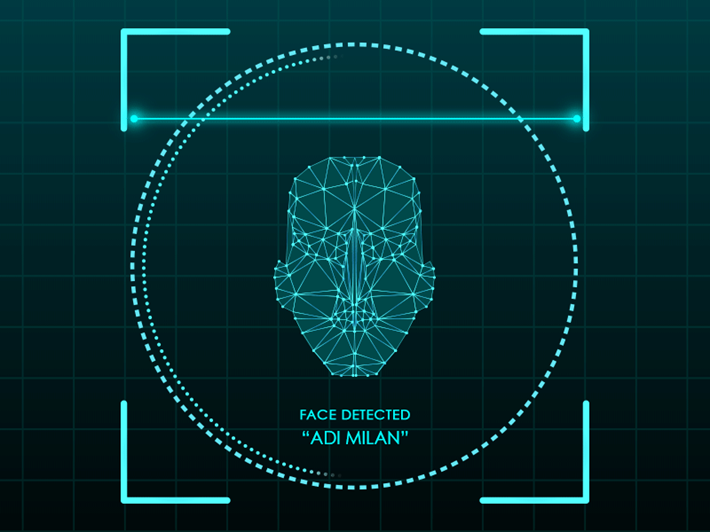



Importar bibliotecas e requerimentos necessários


In [ ]:
import imutils #para redimensionamento e rotacao da imagem
import numpy as np #trabalha na parte matematica das imagens, vetores e matrizes
import cv2 #OpenCV ajuda no processo de deteccao da face
from google.colab.patches import cv2_imshow #dependencias do GC pra representar img
from IPython.display import display, Javascript #display mostra img na tela
#biblioteca Javascript para leitura da webcam do computador
from google.colab.output import eval_js #depend. do CG para saida dos resultados
#eval pra leitura da webcam com javascript
from base64 import b64decode #converte imagens em formato binario

Inicia a webcam para entrada da imagem e detecção da face. Função take_photo faz a leitura da camera.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Clique em 'Capturar' para fazer a foto usando sua webcam.


In [ ]:
image_file = take_photo()

<IPython.core.display.Javascript object>

Leia, redimensione e exiba a imagem.

400 300


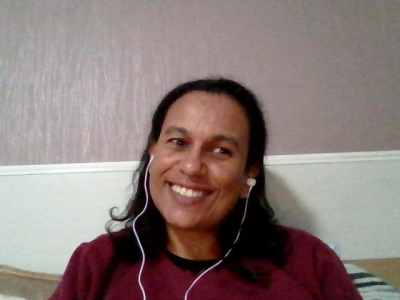

In [ ]:
image = cv2.imread(image_file)

# redimensiona para ter uma largura máxima de 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)  
cv2_imshow(image) #imprime a imagem

O detector de face em Deep Learning do OpenCV é baseado na estrutura Single Shot Detector (SSD) com uma rede base ResNet. A rede é definida e treinada usando o Caffe Deep Learning framework

Baixe o modelo de detecção de rosto pré-treinado, composto por dois arquivos:

    A definição de rede (deploy.prototxt)
    Os pesos aprendidos (res10_300x300_ssd_iter_140000.caffemodel)



In [ ]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2022-06-23 00:17:45--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.003s  

Last-modified header missing -- time-stamps turned off.
2022-06-23 00:17:45 (8.54 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2022-06-23 00:17:45--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

Carregar o modelo de rede de detecção facial pré-treinado do disco

In [ ]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'  #carrega os pesos de treinamento
net = cv2.dnn.readNetFromCaffe(prototxt, model) #carrega o modelo 

[INFO] loading model...


Use a função dnn.blobFromImage para construir um blob de entrada,  redimensionar a imagem para 300x300 pixels fixos e normalizá-la.


In [ ]:
# redimensiona para ter uma largura máxima de 400 pixels; formata o quadrado que marca a detecção
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

Computar a detecção do objeto

In [ ]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing object detections...


Faça um loop para as detecções e desenhe caixas ao redor dos rostos detectados

In [ ]:
for i in range(0, detections.shape[2]):

	# extrair a probabilidade associada à previsão
	confidence = detections[0, 0, i, 2]

	# filtra detecções fracas garantindo que a "confiança" seja
	# maior que o limite mínimo de confiança
	if confidence > 0.5: #A detecção deve ter no mínimo 50% de certeza
		# calcula as coordenadas (x, y) da caixa delimitadora do objeto
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# desenha a caixa delimitadora da face junto com a probabilidade associada
		text = "{:.2f}%".format(confidence * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

Mostra a imagem resultante


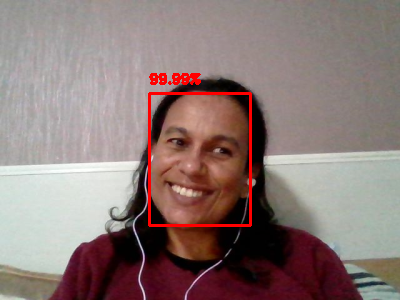

In [ ]:
cv2_imshow(image)   